# ANEXO 1: CÓDIGO EN PYTHON PARA REPLICAR, CORREGIR, ADAPTAR...

## 1) Instalaciones e Importaciones de Librerías Previas:

- Instalamos el módulo necesario para leer la base de datos, que se proporcionan en SPSS

In [1]:
!pip install pyreadstat

- Instalamos el módulo necesario para hacer el análisis factorial

In [2]:
!pip install factor-analyzer==0.3.2

In [3]:
!pip install semopy

- Importamos las librerías necesarias:
    - pandas con el nombre pd
    - numpy con el nombre np
    - scipy con el nombre sp

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
from typing import List
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
from scipy.stats import chi2, pearsonr
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, TransformerMixin
from factor_analyzer.rotator import Rotator
from factor_analyzer.rotator import POSSIBLE_ROTATIONS, OBLIQUE_ROTATIONS
from sklearn.utils.extmath import randomized_svd
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
import sklearn.preprocessing
from typing import List
from semopy import Model
from semopy import Optimizer

## 2) Cargamos bases de datos de la ola 6 y la ola 8 de ELSA

💛 *medioumfortest*  son bases de datos con el 1% de los sujetos. Se debe sustituir por la bases de datos completa.
- Ola 6

In [5]:
w6_df: pd.core.frame.DataFrame = pd.read_spss('data/wave_6_elsa_data_v2_mediumfortest.sav', convert_categoricals = False)

- Ola 8

In [6]:
w8_df: pd.core.frame.DataFrame = pd.read_spss('data/wave_8_elsa_data_eul_v2_mediumfortest.sav', convert_categoricals = False)

## 3) Construcción teórica de Cuestionarios

Estructura y columnas de la base de datos general que los componen

### 3.1) Ola 6

- Isolation para la ola 6 -> isolation_w6_df

Nomenclatura: 
>`vip`: persona/s importantes: children, family y friends.

>`has_vip`: tiene a esa persona/personas importantes. Es decir, tiene niños, familia, amigos.

In [7]:
isolation_w6_chd_items = {
    'has_vip': ['scchd'],
    'kind_of_contact': ['scchdg', 'scchdh', 'scchdi', 'scchdt'],
}
isolation_w6_fam_items = {
    'has_vip': ['scfam'],
    'kind_of_contact': ['scfamg', 'scfamh', 'scfami', 'scfamt'],
}
isolation_w6_frd_items = {
    'has_vip': ['scfrd'],
    'kind_of_contact': ['scfrdg', 'scfrdh', 'scfrdi', 'scfrdt'],
}

isolation_w6_org_contact = 'scorg09'
isolation_w6_prt_contact = 'scprtr'

isolation_w6_relatives = [isolation_w6_chd_items, isolation_w6_fam_items, isolation_w6_frd_items]

- Casp-19 para la ola 6 -> casp19_w6

In [8]:
casp19_w6_control = ['scqola', 'scqolb', 'scqolc', 'scqold']
casp19_w6_autonomy = ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli']
casp19_w6_pleasure = [ 'scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln']
casp19_w6_self_realization = ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']

casp19_w6_scales = [casp19_w6_control, casp19_w6_autonomy, casp19_w6_pleasure, casp19_w6_self_realization]

casp19_original_values = [1, 2, 3, 4]
casp19_w6_reverse_items_values = [0, 1, 2, 3]
casp19_w6_direct_items_values = [3, 2, 1, 0]

* Insatisfacción sexual para la ola 6 (mujeres) -> sexdissa_w6_f

In [9]:
sexdissa_w6_f_cols = ['q3', 'q9', 'q10', 'q14f', 'q15f', 'q19m19f', 'q28m25f', 'q32m26f']

* Insatisfacción sexual para la ola 6 (hombres) -> sexdissa_w6_m

In [10]:
sexdissa_w6_m_cols = ['q3', 'q9', 'q10', 'q13m', 'q17m', 'q19m19f', 'q21m', 'q28m25f', 'q32m26f']

* Multimorbilidad

Si la persona confirma que la enfermedad registrada en el pasado está correctamente registrada (hedac-/hedbd- = yes) y que aún la tiene (hedas-/hedbs- = yes) o bien desmiente que le tuviera (hedac-/hedbd- = No) pero dice tenerla ahora ((hedan-/hedbm- = 3) o la reporta ahora (hedia-/hedib- = 1 "mentioned") entonces se imputará un uno sobre esa enfermedad. Si, en suma, hay más de un uno se asignará un uno a la variable de comorbilidad. 

In [11]:
cvd = ['bp', 'an', 'mi', 'hf', 'hm', 'ar', 'di', 'st', 'ch', '95']
chr_ = ['lu', 'as', 'ar', 'os', 'ca', 'pd', 'ps', 'ad', 'de', 'bl'] # ps: psychiatric
psy = ['ha', 'an', 'de', 'em', 'sc', 'ps', 'mo', 'ma']

lex_diagnosed_fedforward_cvd = 'hedaw' 
lex_diagnosed_fedforward_chr = 'hedbw'
# hedaw- y hedbw- puede que no las necesite

lex_what_psy = 'hepsy'

lex_confirm_cvd = 'hedac'
lex_confirm_chr = 'hedbd'

lex_still_has_cvd = 'hedas'
lex_still_has_chr = 'hedbs'

lex_dispute_cvd = 'hedan'
lex_dispute_chr = 'hedbm'
       
lex_new_cvd = 'hedia'
lex_new_chr = 'hedib'

In [13]:
diagnosed_fedforward_cvd = [lex_diagnosed_fedforward_cvd + i for i in cvd]
diagnosed_fedforward_chr = [lex_diagnosed_fedforward_chr + i for i in chr_]

what_psy = [lex_what_psy + i for i in psy]

still_has_cvd = [lex_still_has_cvd + i for i in cvd]
still_has_chr = [lex_still_has_chr + i for i in chr_]


confirm_cvd = [lex_confirm_cvd + i for i in cvd]
confirm_chr = [lex_confirm_chr + i for i in chr_]


dispute_cvd = [lex_dispute_cvd + i for i in cvd]
dispute_chr = [lex_dispute_chr + i for i in chr_]
       
new_cvd = [lex_new_cvd + i for i in cvd]
new_chr = [lex_new_chr + i for i in chr_]

### 3.2) Ola 8

- Isolation para la ola 8 -> isolation_w8_df

In [14]:
isolation_w8_chd_items = {
    'has_vip': ['scchd'],
    'kind_of_contact': ['scchdh', 'scchdi', 'scchdj', 'scchdk'],
}
isolation_w8_fam_items = {
    'has_vip': ['scfam'],
    'kind_of_contact': ['scfamh', 'scfami', 'scfamt', 'scfamk'],
}
isolation_w8_frd_items = {
    'has_vip': ['scfrd'],
    'kind_of_contact': ['scfrdh', 'scfrdi', 'scfrdt', 'scfamk'],
}

isolation_w8_org_contact = 'scorg96'
isolation_w8_prt_contact = 'scprt'

isolation_w8_relatives = [isolation_w8_chd_items, isolation_w8_fam_items, isolation_w8_frd_items]

- Casp-19 para la ola 8 -> casp19_w8

In [15]:
casp19_w8_control = ['scqola', 'scqolb', 'scqolc', 'scqold']
casp19_w8_autonomy = ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli']
casp19_w8_pleasure = [ 'scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln']
casp19_w8_self_realization = ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']

casp19_w8_scales = [casp19_w6_control, casp19_w6_autonomy, casp19_w6_pleasure, casp19_w6_self_realization]

casp19_original_values = [1, 2, 3, 4]
casp19_w8_reverse_items_values = [0, 1, 2, 3]
casp19_w8_direct_items_values = [3, 2, 1, 0]

* Insatisfacción sexual para la ola 8 (mujeres) -> sexdissa_w8_f

In [16]:
sexdissa_w8_f_cols = ['sxwdy', 'sxwofy', 'sxhaf', 'sxfpdy', 'sxfway', 'sxwoey', 'sxsosy', 'sxwsty']

* Insatisfacción sexual para la ola 8 (hombres) -> sexdissa_w8_m

In [17]:
sexdissa_w8_m_cols = ['sxwdy', 'sxwofy', 'sxhsaf', 'sxmwey', 'sxmcoy', 'sxwoey', 'sxsosy', 'sxwsty']

* Multimorbilidad

Las variables se llaman igual que en la ola 6

* Percibed health

## 4) Tratamiento de valores perdidos de los primeros cuestionarios:

Lo hacemos de esta manera para teneer la mayor cantidad de sujetos posible a la hora de hacer los análisis factoriales 

### 4.1) Ola 6

- **"-2": "schedule not aplicable"** :  *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1604 sujetos no han recibido este módulo del cuestionario* 

#### Columnas, pertenecientes a cuestionarios, que van a ser limpiadas

In [18]:
isolation_w6_cols = ['scchdg', 'scchdh', 'scchdi', 'scchdt', 
                     'scfamg', 'scfamh', 'scfami', 'scfamt', 
                     'scfrdg', 'scfrdh', 'scfrdi', 'scfrdt', 
                     'scorg09', 
                     'scprtr']
casp19_w6_cols = ['scqola', 'scqolb', 'scqolc', 'scqold', 'scqole', 
               'scqolf', 'scqolg', 'scqolh', 'scqoli', 'scqolj', 
               'scqolk', 'scqoll', 'scqolm', 'scqoln', 'scqolo', 
               'scqolp', 'scqolq', 'scqolr', 'scqols']

In [19]:
cols_to_clean_out_of_sample_w6 = isolation_w6_cols + casp19_w6_cols

#### sujetos seleccionados para ser eliminados 

traducción: 
> Constrúyeme una variable (llamada sbj_out_of_sample) que sea igual a: me localizas en el dataframe w6_df `w6_df.loc` lo que te voy a decir: `[` construye un pandas dataframe `pd.DataFrame` con lo siguiente `(`: mira cuales cumplen `==` que son un elemento del w6_df igual a -2 `)` (eso devuelve un True o False) y hazlo para `for` cada elemento `col` en `in` la variable cols_to_clean_out_of_sample (ya definida). Hazlo si en esta lista `[]` lo hay en ALGUNA (de las columnas)`any()`. Bien, cuando lo tengas localizado `]`, coge el índice `.index()`.

In [20]:
sbj_out_of_sample_w6 = w6_df.loc[pd.DataFrame([(w6_df[col] == -2) for col in cols_to_clean_out_of_sample_w6]).any()].index
sbj_out_of_sample_w6 # Resultado: Int64Index([5, 9, 16, 17, 18, 19, 62, 65, 71, 89, 91, 93, 96], dtype='int64')

Int64Index([5, 9, 16, 17, 18, 19, 62, 65, 71, 89, 91, 93, 96], dtype='int64')

#### Construimos el dataframe sin los sujetos
traducción:
>Construye una variable (tipo df por cómo se compone) que sea: el dataframe w6_df quitándole `.drop` los sujetos seleccionados.

In [21]:
w6_without_sbj_out_of_sample_df =  w6_df.drop(sbj_out_of_sample_w6)
w6_without_sbj_out_of_sample_df #del 88 pasa al 90 y luego al 92 porque el 89 y el 91 se eliminaron

,idauniq,idahhw6,perid,samptyp,w6indout,W6hhout,couple,cpid,chinhh,chouthh,...,w6nssec8,w6nssec5,w6nssec3,W6SIC,w6soc,W6SEC,w6sic2003,w6soc2000,w6nssec13,finstatw6
0,103890.0,11743.0,1.0,1.0,11.0,120.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,0.0,0.0,0.0,-1.0,35.0,4.3,1.0
1,103895.0,16260.0,1.0,1.0,11.0,110.0,1.0,2.0,1.0,1.0,...,5.0,4.0,3.0,0.0,0.0,0.0,-1.0,92.0,10.0,1.0
2,103960.0,14747.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,1.0,...,7.0,5.0,3.0,0.0,0.0,0.0,-1.0,62.0,13.3,1.0
3,104192.0,15705.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,1.0,...,4.0,3.0,2.0,0.0,0.0,0.0,-1.0,51.0,9.2,1.0
4,104194.0,16507.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,2.0,...,6.0,5.0,3.0,0.0,0.0,0.0,-1.0,41.0,12.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,165305.0,11882.0,1.0,1.0,11.0,110.0,1.0,2.0,2.0,1.0,...,5.0,4.0,3.0,1.0,1.0,1.0,63.0,91.0,10.0,25.0
90,165365.0,14517.0,1.0,1.0,11.0,110.0,3.0,-1.0,1.0,2.0,...,6.0,5.0,3.0,1.0,1.0,1.0,80.0,61.0,12.7,25.0
92,165537.0,11512.0,2.0,1.0,11.0,110.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,11.0,2.0,25.0
94,165858.0,10999.0,3.0,-1.0,11.0,110.0,1.0,1.0,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,74.0,35.0,4.3,29.0


- **kind_of_contact = "-1" "item not applicable" y has_vip = "-9" "not answered"**: *sujetos que van a ser eliminados porque no contestaron a si tenían VIP y el ítem de tipo de contacto no es aplicable*

#### Columnas que se van a inspeccionar para ver qué sujetos cumplen las condiciones para ser eliminados:

In [22]:
cols_to_clean_didnt_awr_hasvip_w6 = ['scchd', 'scfam', 'scfrd']
cols_to_clean_kind_of_contact_not_applicable_w6 = [['scchdg', 'scchdh', 'scchdi', 'scchdt'], 
                                                ['scfamg', 'scfamh', 'scfami', 'scfamt'], 
                                                ['scfrdg', 'scfrdh', 'scfrdi', 'scfrdt']]

#### Función que vamos a utilizar para eliminar sujetos
Traducción: 
> Define `def` la función (llamada *delete_sbj_didnt_awr_kind_of_contact_not_applicable*) que para cada sujeto devuelva un buleano `bool` (True o False). Hazlo (devolver True) si se cumple que en algún `any` caso el sujeto no contesta (-9) a si tiene personas importantes (vip: friends, children, family) `sbj[has_vip] == -9` y a la vez `and` si alguno `any` de los sujetos tiene en la *columna* un valor de -1, lo haces para cada `[i]` lista de columnas de las *cols_to_clean_kind_of_contact_not_applicable_w6*. Y ahora, hazme todo eso que te he dicho con cada elemento `i` de has_vip y con cada elemento de *cols_to_clean_didnt_awr_hasvip_w6* dándome indice y el elemento de la lista (esto es lo que hace *enumerate*: te asocia cada i de has_vip con cada elemento de la lista a la que se refiere enumerate) 

In [23]:
def is_sbj_didnt_awr_kind_of_contact_not_applicable(sbj) -> bool:
    return any([
        sbj[has_vip] == -9 and any([
            sbj[col] == -1 for col in cols_to_clean_kind_of_contact_not_applicable_w6[i]])
        for i, has_vip in enumerate(cols_to_clean_didnt_awr_hasvip_w6)])

reducimos de nuevo el dataframe, sobre el que ya estaba reducido, esta vez para eliminar los nuevos sujetos seleccionados:

#### Construimos El data frame is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df aplicando 
Traducción: 
> 

In [24]:
is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df = w6_without_sbj_out_of_sample_df.apply(
                                                            is_sbj_didnt_awr_kind_of_contact_not_applicable
                                                            ,
                                                            axis=1)
w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df = w6_without_sbj_out_of_sample_df.loc[
    is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df == False]

In [25]:
# w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df

- **has_vip = "1" "yes" y kind_of_contact = "-9" "not answered"**: *sujetos que tienen vip pero no contestan a alguna de las preguntas. Tenemos que calcular su puntuación basándonos en el resto de respuestas.*

In [26]:
def sustitution_missing_kind_of_contact(sbj,scale: dict) -> [0, 1]: 
    return 0 if (any([
        sbj[scale['kind_of_contact']] == -9 and any([
            sbj[col] == 0 for col in kind_of_contact])])) else 1 if any([
                sbj[scale['kind_of_contact']] == -9 and all([
                    sbj[col] == 1 for col in kind_of_contact])
                ]) else 0 #16

- **Has_vip = "2" "No" y kind_of_contact = "-1" "item not applicable"**: *sujetos que no tienen vip y lógicamente no tienen ningún tipo de contacto con ese vip. Debemos imputar directamente un punto de isolation para esta subescala. El tratamiento se hace directamente en la construcción del cuestionario.* 

- Eliminamos a los sujetos menores de 50 años

In [ ]:
#18

- En CASP-19 no han contestado a alguna de las preguntas (-9) dentro de las subescalas

In [31]:
#19

#### ( ! )  Base de datos limpiada de valores perdidos de los primeros cuestionarios de ola 6

In [32]:
w6_first_cleaned_df = w6_without_sbj_didnt_awr_kind_of_contact_not_applicable_df  #20

### 4.2) Ola 8 

- **"-2": "Self-completion instrument not completed"** :  *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1223 sujetos no han recibido este módulo del cuestionario* 

#### Columnas, pertenecientes a cuestionarios, que van a ser limpiadas

In [33]:
isolation_w8_cols = ['scchdh', 'scchdi', 'scchdj', 'scchdk',
                     'scfamh', 'scfami', 'scfamj', 'scfamk',
                     'scfrdh', 'scfrdi', 'scfrdj', 'scfrdk',
                     'scorg96', 
                     'scprt']
casp19_w8_cols = ['scqola', 'scqolb', 'scqolc', 'scqold', 'scqole', 
               'scqolf', 'scqolg', 'scqolh', 'scqoli', 'scqolj', 
               'scqolk', 'scqoll', 'scqolm', 'scqoln', 'scqolo', 
               'scqolp', 'scqolq', 'scqolr', 'scqols']

In [34]:
cols_to_clean_out_of_sample_w8 = isolation_w8_cols + casp19_w8_cols

#### sujetos seleccionados para ser eliminados 

traducción: 
> Constrúyeme una variable (llamada sbj_out_of_sample) que sea igual a: me localizas en el dataframe w8_df `w8_df.loc` lo que te voy a decir: `[` construye un pandas dataframe `pd.DataFrame` con lo siguiente `(`: mira cuales cumplen `==` que son un elemento del w8_df igual a -2 `)` (eso devuelve un True o False) y hazlo para `for` cada elemento `col` en `in` la variable cols_to_clean_out_of_sample_w8 (ya definida). Hazlo si en esta lista `[]` lo hay en ALGUNA (de las columnas)`any()`. Bien, cuando lo tengas localizado `]`, coge el índice `.index()`.

In [35]:
sbj_out_of_sample_w8 = w8_df.loc[pd.DataFrame([(w8_df[col] == -2) for col in cols_to_clean_out_of_sample_w8]).any()].index
sbj_out_of_sample_w8 

Int64Index([9, 20, 23, 28, 35, 39, 47, 50, 51, 52, 57, 62, 63, 64, 66, 68, 75,
            76],
           dtype='int64')

#### Construimos el dataframe sin los sujetos
traducción:
>Construye una variable (tipo df por cómo se compone) que sea: el dataframe w8_df quitándole `.drop` los sujetos seleccionados.

In [36]:
w8_without_sbj_out_of_sample_df =  w8_df.drop(sbj_out_of_sample_w8)
w8_without_sbj_out_of_sample_df.head()

,idauniq,idahhw8,perid,samptyp,finstat,w8indout,w8hhout,w8scout,w8sscout,w8nurout,...,w8nssec5,w8nssec3,w8soc2000r,w8sic2003r,gor,w8w1lwgt,w8w4lwgt,w8xwgt,w8scwt,w8sscwt
0,117573.0,10116.0,1.0,1.0,1.0,11.0,110.0,1.0,1.0,81.0,...,1.0,1.0,35.0,-1.0,E12000008,1.736654,2.036621,1.362483,1.589579,1.885873
1,161881.0,10118.0,2.0,1.0,14.0,11.0,110.0,1.0,1.0,81.0,...,5.0,3.0,62.0,-1.0,E12000006,NaN,1.274136,6.554409,6.735195,5.763463
2,151416.0,10134.0,1.0,1.0,7.0,11.0,110.0,1.0,1.0,81.0,...,4.0,3.0,62.0,-1.0,E12000007,NaN,1.559035,1.590436,1.631708,1.316570
3,120968.0,10219.0,2.0,1.0,1.0,11.0,110.0,1.0,3.0,81.0,...,5.0,3.0,71.0,-1.0,E12000001,1.030250,0.793539,0.670783,0.627842,NaN
4,160230.0,10220.0,1.0,1.0,14.0,11.0,110.0,1.0,1.0,-1.0,...,1.0,1.0,32.0,-1.0,E12000005,NaN,1.050260,0.436357,0.410924,0.374231


- **kind_of_contact = "-1" "item not applicable" y has_vip = "-9" "not answered"**: *sujetos que van a ser eliminados porque no contestaron a si tenían VIP y el ítem de tipo de contacto no es aplicable* 

#### Columnas que se van a inspeccionar para ver qué sujetos cumplen las condiciones para ser eliminados:

In [ ]:
#23

In [37]:
cols_to_clean_didnt_awr_hasvip_w6 = ['scchd', 'scfam', 'scfrd']
cols_to_clean_kind_of_contact_not_applicable_w6 = [['scchdg', 'scchdh', 'scchdi', 'scchdt'], 
                                                ['scfamg', 'scfamh', 'scfami', 'scfamt'], 
                                                ['scfrdg', 'scfrdh', 'scfrdi', 'scfrdt']]

#### Función que vamos a utilizar para eliminar sujetos
Traducción: 
> Define `def` la función (llamada *delete_sbj_didnt_awr_kind_of_contact_not_applicable*) que para cada sujeto devuelva un buleano `bool` (True o False). Hazlo (devolver True) si se cumple que en algún `any` caso el sujeto no contesta (-9) a si tiene personas importantes (vip: friends, children, family) `sbj[has_vip] == -9` y a la vez `and` si alguno `any` de los sujetos tiene en la *columna* un valor de -1, lo haces para cada `[i]` lista de columnas de las *cols_to_clean_kind_of_contact_not_applicable_w6*. Y ahora, hazme todo eso que te he dicho con cada elemento `i` de has_vip y con cada elemento de *cols_to_clean_didnt_awr_hasvip_w6* dándome indice y el elemento de la lista (esto es lo que hace *enumerate*: te asocia cada i de has_vip con cada elemento de la lista a la que se refiere enumerate) 

In [38]:
def is_sbj_didnt_awr_kind_of_contact_not_applicable(sbj) -> bool:
    return any([
        sbj[has_vip] == -9 and any([
            sbj[col] == -1 for col in cols_to_clean_kind_of_contact_not_applicable_w6[i]])
        for i, has_vip in enumerate(cols_to_clean_didnt_awr_hasvip_w6)])

reducimos de nuevo el dataframe, sobre el que ya estaba reducido, esta vez para eliminar los nuevos sujetos seleccionados:

#### Construimos El data frame is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df aplicando 
Traducción: 
> 

In [39]:
is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df = w8_without_sbj_out_of_sample_df.apply(
                                                            is_sbj_didnt_awr_kind_of_contact_not_applicable
                                                            ,
                                                            axis=1)
w8_without_sbj_didnt_awr_kind_of_contact_not_applicable = w8_without_sbj_out_of_sample_df.loc[
    is_sbj_didnt_awr_kind_of_contact_not_applicable_w6_df == False]

In [40]:
# w8_without_sbj_didnt_awr_kind_of_contact_not_applicable

- **has_vip = "1" "yes" y kind_of_contact = "-9" "not answered"**: *sujetos que tienen vip pero no contestan a alguna de las preguntas. Tenemos que calcular su puntuación basándonos en el resto de respuestas.*

In [41]:
def sustitution_missing_kind_of_contact(sbj,scale: dict) -> [0, 1]: 
    return 0 if (any([
        sbj[scale['kind_of_contact']] == -9 and any([
            sbj[col] == 0 for col in kind_of_contact])])) else 1 if any([
                sbj[scale['kind_of_contact']] == -9 and all([
                    sbj[col] == 1 for col in kind_of_contact])
                ]) else 0 # TODO: caso no contemplado, mirar que hacer con estos valores kind_of_contact = [-9, 1, -9, 1]

- **Has_vip = "2" "No" y kind_of_contact = "-1" "item not applicable"**: *sujetos que no tienen vip y lógicamente no tienen ningún tipo de contacto con ese vip. Debemos imputar directamente un punto de isolation para esta subescala. El tratamiento se hace directamente en la construcción del cuestionario.* 

- Eliminamos a los sujetos menores de 50 años

In [44]:
#27

- En CASP-19 no han contestado a alguna de las preguntas (-9) dentro de las subescalas

In [45]:
#28

#### ( ! )  Base de datos limpiada de valores perdidos de los primeros cuestionarios de ola 8

In [46]:
w8_first_cleaned_df = w8_without_sbj_didnt_awr_kind_of_contact_not_applicable  # sustituir por la última reducción del dataframe

 ## 5) Construcción funcional de cuestionarios

### 5.1) Ola 6

- Isolation para la ola 6 -> isolation_w6_df

#### Función que dicotomiza una respuesta likert 

In [48]:
def dichotomize_item(likert_answer: int) -> [0, 1]: 
       return 0 if likert_answer in range(1, 3 + 1) \
        else 1 if likert_answer in range(4, 6 + 1) else 0 #29

#### Funcion que reduce las subescalas con múltiples items a subescalas con un solo item y además es dicotómica

In [49]:
def reduce_scale_to_one_item(sbj, scale: dict) -> [0, 1]: 
    if sbj[scale['has_vip']][0] == 2:
        return 1
    else:
        relative_inters = [dichotomize_item(sbj[item]) for item in scale['kind_of_contact']]  
        relative = 1 if all([relative_inter == 1 for relative_inter in relative_inters]) else 0
    return relative

#### Funcion que dicotomiza una respuesta simple, dicotómica, a una respuesta dicotomica (añadiendo un "y si encuentras otra cosa dame un cero")

In [52]:
def reduce_simple_subscale(sbj, item) -> [0, 1]: 
    return sbj[item] if sbj[item] in [0, 1] else 0 #29

Traducción: 
> Define la función llamada calc_isolation_w6 para cada sujeto `sbj`. El resultado será 0, 1, 2, 3, 4 o 5. 
> Relatives será el resultado de aplicar la función reduce_scale_to_one_item a cada sujeto `sbj` de cada elemento de isolation_w6_relatives `x` en `for` cada 
> elemento `x` de `in` isolation_w6_relatives
> Isolation será la suma de 

#### Función que calcula el valor de isolation

Traducción:
> Definimos `relatives` como _lista que resulta de que apliques esta función_: aplica _reduce_scale_to_one_item_ a cada sujeto `sbj` para cada elemento `x` de _isolation_w6_relatives_ 
> _isolation_w6_relatives_ es la _scale_ que te estoy dando como parámetro de la función _reduce_scale_to_one_item_ (más arriba)
    

In [54]:
def calc_items_isolation_w6(sbj):
    relatives = [reduce_scale_to_one_item(sbj, x) for x in isolation_w6_relatives] 
    return relatives + [reduce_simple_subscale(sbj, isolation_w6_org_contact)] + [reduce_simple_subscale(sbj, isolation_w6_prt_contact)]

In [55]:
def calc_isolation_w6(sbj) -> [0, 1, 2, 3, 4, 5]:
    isolation = sum(calc_items_isolation_w6(sbj))
    return isolation

In [56]:
items_isolation_w6_df = w6_first_cleaned_df.loc[(w6_first_cleaned_df['indager'] >= 50)].apply(calc_items_isolation_w6, axis=1, result_type='expand')

In [57]:
isolation_w6_df = w6_first_cleaned_df.loc[(w6_first_cleaned_df['indager'] >= 50)].apply(calc_isolation_w6, axis=1)

In [58]:
items_isolation_w6_df

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
88,0.0,0.0,0.0,1.0,1.0
90,0.0,1.0,0.0,1.0,0.0
92,0.0,0.0,0.0,0.0,1.0
94,0.0,1.0,0.0,1.0,1.0


In [59]:
isolation_w6_df.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    3.0
dtype: float64

- Cuestionario CASP-19 en ola 6

#### Especificamos los ítems directos e inversos

In [60]:
casp19_w6_reverse_items = [
    'scqola', 
    'scqolb',
    'scqold', 
    'scqolf',
    'scqolh', 
    'scqoli',
]
casp19_w6_direct_items = [
    'scqolc', 
    'scqole', 
    'scqolg',
    'scqolj',
    'scqolk',
    'scqoll',
    'scqolm',
    'scqoln', 
    'scqolo', 
    'scqolp',
    'scqolq', 
    'scqolr',
    'scqols',
]

#### Construinmos las funciones que aplicaremos a los sujetos para crear el cuestionario

Debe tenerse en cuenta que los valores originales en la base de datos están codificados como 1 = often, 2 = Sometimes, 3 = No often y 4 = Never; y el cuestionario debe ofrecer una puntuación mayor cuanto mayor sea la calidad de vida del sujeto. De tal manera que un ítem inverso como *I feel that what happens to me is out of my control* (calificado como inverso) si es respondido con *often* se le ha asignado un valor de 1 en la base de datos. 

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems inversos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. devolverá `return` ese valor menos uno. 

In [61]:
def get_reverse_item(x: [1, 2, 3, 4]) -> [0, 1, 2, 3]:
    return x - 1

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems directos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. En este caso devolverá un 0 donde había un 4, un 1 donde había un 3, etc. 

In [62]:
def get_direct_item(x: [1, 2, 3, 4]) -> [3, 2, 1, 0]:
    return (x - 4) * (-1)

Traducción
> Definimos la función que calculará la puntuación del cuestionario CASP-19 para la ola 6 que dará como resultado un único valor entero comprendido entre cero y 57. 
Esta función devuelve `return` la suma de dos elementos: El primero se obtiene de aplicar la función get_reverse_ item a cada valor *reverse_item* de cada sujeto para cada valor de item reverso de la lista de items inversos. El segundo elemento de la suma se obtiene de aplicar la función get_direct_item a cada valor *direct_item* de cada sujeto para cada ítem directo de la lista de ítems directos del CASP-19 de la ola 6

Función para obtener los tems transformados del cuestionario CASP-19_w6

In [63]:
def transform_casp19_items(sbj) -> List[int]:  # int -> [0, 1, 2, 3]
    return ([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_w6_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_w6_direct_items])

Función para calcular el valor del cuestionario CASP-19

In [64]:
def calc_casp19_w6(sbj) -> list(range(57)):
    return sum([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_w6_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_w6_direct_items])

#### Obtenemos los items del cuestionario CASP-19

In [65]:
items_casp19_w6_df = w6_first_cleaned_df.apply(transform_casp19_items, axis=1, result_type='expand')

#### Creamos el cuestionario aplicando las funciones para su creación

In [66]:
casp19_w6 = w6_first_cleaned_df.apply(calc_casp19_w6, axis=1)

In [67]:
casp19_w6

0     53.0
1     35.0
2     49.0
3     48.0
4     41.0
      ... 
88    40.0
90    53.0
92    42.0
94    45.0
95    38.0
Length: 84, dtype: float64

* Multimorbilidad

In [70]:
def calc_morbility_cvd (sbj) -> [0, 1]:
    return 1 if ((i == 1 for i in enumerate[confirm_cvd]) and (i == 1 for i in enumerate[still_has_cvd])) or ((i == 2 for i in enumerate[confirm_cvd]) and (i == 3 for i in enumerate[dispute_cvd])) or ((i == 2 for i in enumerate[confirm_cvd]) and (i == 2 for i in enumerate[dispute_cvd])) or (i == 1 for i in enumerate[new_cvdelse]) else 0

CVD

In [71]:
def calc_morbility_cvd_bp (sbj) -> [0, 1]:
    return 1 if (('hedacbp' == 1) and ('hedasbp' == 1)) or (('hedacbp' == 2) and ('hedanbp' == 2)) or (('hedacbp' == 2) and ('hedanbp' == 3)) or ('hediabp' == 1) else 0

In [72]:
def calc_morbility_cvd_an (sbj) -> [0, 1]:
    return 1 if (('hedacan' == 1) and ('hedasan' == 1)) or (('hedacan' == 2) and ('hedanan' == 2)) or (('hedacan' == 2) and ('hedanan' == 3)) or ('hediaan' == 1) else 0

In [73]:
def calc_morbility_cvd_mi (sbj) -> [0, 1]:
    return 1 if (('hedacmi' == 1) and ('hedasmi' == 1)) or (('hedacmi' == 2) and ('hedanmi' == 2)) or (('hedacmi' == 2) and ('hedanmi' == 3)) or ('hediami' == 1) else 0

In [74]:
def calc_morbility_cvd_hf (sbj) -> [0, 1]:
    return 1 if (('hedachf' == 1) and ('hedashf' == 1)) or (('hedachf' == 2) and ('hedanhf' == 2)) or (('hedachf' == 2) and ('hedanhf' == 3)) or ('hediahf' == 1) else 0

In [75]:
def calc_morbility_cvd_hm (sbj) -> [0, 1]:
    return 1 if (('hedachm' == 1) and ('hedashm' == 1)) or (('hedachm' == 2) and ('hedanhm' == 2)) or (('hedachm' == 2) and ('hedanhm' == 3)) or ('hediahm' == 1) else 0

In [76]:
def calc_morbility_cvd_ar (sbj) -> [0, 1]:
    return 1 if (('hedacar' == 1) and ('hedasar' == 1)) or (('hedacar' == 2) and ('hedanar' == 2)) or (('hedacar' == 2) and ('hedanar' == 3)) or ('hediaar' == 1) else 0

In [77]:
def calc_morbility_cvd_di (sbj) -> [0, 1]:
    return 1 if (('hedacdi' == 1) and ('hedasdi' == 1)) or (('hedacdi' == 2) and ('hedandi' == 2)) or (('hedacdi' == 2) and ('hedandi' == 3)) or ('hediadi' == 1) else 0

In [78]:
def calc_morbility_cvd_st (sbj) -> [0, 1]:
    return 1 if (('hedacst' == 1) and ('hedasst' == 1)) or (('hedacst' == 2) and ('hedanst' == 2)) or (('hedacst' == 2) and ('hedanst' == 3)) or ('hediast' == 1) else 0

In [79]:
def calc_morbility_cvd_ch (sbj) -> [0, 1]:
    return 1 if (('hedacch' == 1) and ('hedasch' == 1)) or (('hedacch' == 2) and ('hedanch' == 2)) or (('hedacch' == 2) and ('hedanch' == 3)) or ('hediach' == 1) else 0

In [80]:
def calc_morbility_cvd_95 (sbj) -> [0, 1]:
    return 1 if (('hedac95' == 1) and ('hedas95' == 1)) or (('hedac95' == 2) and ('hedan95' == 2)) or (('hedac95' == 2) and ('hedan95' == 3)) or ('hedia95' == 1) else 0

Chronic

In [81]:
def calc_morbility_chr_lu (sbj) -> [0, 1]:
    return 1 if (('hedaclu' == 1) and ('hedbslu' == 1)) or (('hedaclu' == 2) and ('hedbmlu' == 2)) or (('hedaclu' == 2) and ('hedbmlu' == 3)) or ('hediblu' == 1) else 0

In [82]:
def calc_morbility_chr_as (sbj) -> [0, 1]:
    return 1 if (('hedacas' == 1) and ('hedbsas' == 1)) or (('hedacas' == 2) and ('hedbmas' == 2)) or (('hedacas' == 2) and ('hedbmas' == 3)) or ('hedibas' == 1) else 0

In [83]:
def calc_morbility_chr_ar (sbj) -> [0, 1]:
    return 1 if (('hedacar' == 1) and ('hedbsar' == 1)) or (('hedacar' == 2) and ('hedbmar' == 2)) or (('hedacar' == 2) and ('hedbmar' == 3)) or ('hedibar' == 1) else 0

In [84]:
def calc_morbility_chr_os (sbj) -> [0, 1]:
    return 1 if (('hedacos' == 1) and ('hedbsos' == 1)) or (('hedacos' == 2) and ('hedbmos' == 2)) or (('hedacos' == 2) and ('hedbmos' == 3)) or ('hedibos' == 1) else 0

In [85]:
def calc_morbility_chr_ca (sbj) -> [0, 1]:
    return 1 if (('hedacca' == 1) and ('hedbsca' == 1)) or (('hedacca' == 2) and ('hedbmca' == 2)) or (('hedacca' == 2) and ('hedbmca' == 3)) or ('hedibca' == 1) else 0

In [86]:
def calc_morbility_chr_pd (sbj) -> [0, 1]:
    return 1 if (('hedacpd' == 1) and ('hedbspd' == 1)) or (('hedacpd' == 2) and ('hedbmpd' == 2)) or (('hedacpd' == 2) and ('hedbmpd' == 3)) or ('hedibpd' == 1) else 0

In [87]:
def calc_morbility_chr_ps (sbj) -> [0, 1]:
    return 1 if (('hedacps' == 1) and ('hedbsps' == 1)) or (('hedacps' == 2) and ('hedbmps' == 2)) or (('hedacps' == 2) and ('hedbmps' == 3)) or ('hedibps' == 1) else 0

In [88]:
def calc_morbility_chr_ad (sbj) -> [0, 1]:
    return 1 if (('hedacad' == 1) and ('hedbsad' == 1)) or (('hedacad' == 2) and ('hedbmad' == 2)) or (('hedacad' == 2) and ('hedbmad' == 3)) or ('hedibad' == 1) else 0

In [89]:
def calc_morbility_chr_de (sbj) -> [0, 1]:
    return 1 if (('hedacde' == 1) and ('hedbsde' == 1)) or (('hedacde' == 2) and ('hedbmde' == 2)) or (('hedacde' == 2) and ('hedbmde' == 3)) or ('hedibde' == 1) else 0

In [90]:
def calc_morbility_chr_bl (sbj) -> [0, 1]:
    return 1 if (('hedacbl' == 1) and ('hedbsbl' == 1)) or (('hedacbl' == 2) and ('hedbmbl' == 2)) or (('hedacbl' == 2) and ('hedbmbl' == 3)) or ('hedibbl' == 1) else 0

In [91]:
# def calc_morbility_cvd_w6 (sbj, item) -> List[int]
#    calc_morbility[col] for col[sbj] in 

In [93]:
morbility_cvd_bp_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_bp, axis=1)
morbility_cvd_an_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_an, axis=1)
morbility_cvd_mi_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_mi, axis=1)
morbility_cvd_hf_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_hf, axis=1)
morbility_cvd_hm_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_hm, axis=1)
morbility_cvd_ar_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_ar, axis=1)
morbility_cvd_di_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_di, axis=1)
morbility_cvd_st_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_st, axis=1)
morbility_cvd_ch_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_ch, axis=1)
morbility_cvd_95_w6 = w6_first_cleaned_df.apply(calc_morbility_cvd_95, axis=1)

morbility_cvd_w6_df = pd.DataFrame([morbility_cvd_bp_w6, 
                             morbility_cvd_an_w6,
                             morbility_cvd_mi_w6,
                             morbility_cvd_hf_w6,
                             morbility_cvd_hm_w6,
                             morbility_cvd_ar_w6,
                             morbility_cvd_di_w6,
                             morbility_cvd_st_w6,
                             morbility_cvd_ch_w6,
                             morbility_cvd_95_w6]).transpose()

morbility_cvd_w6_df

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
88,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0


In [94]:
morbility_chr_lu_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_lu, axis=1)
morbility_chr_as_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_as, axis=1)
morbility_chr_ar_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_ar, axis=1)
morbility_chr_os_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_os, axis=1)
morbility_chr_ca_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_ca, axis=1)
morbility_chr_pd_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_pd, axis=1)
morbility_chr_ps_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_ps, axis=1)
morbility_chr_ad_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_ad, axis=1)
morbility_chr_de_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_de, axis=1)
morbility_chr_bl_w6 = w6_first_cleaned_df.apply(calc_morbility_chr_bl, axis=1)

morbility_chr_w6_df = pd.DataFrame([morbility_chr_lu_w6,
                             morbility_chr_as_w6,
                             morbility_chr_ar_w6,
                             morbility_chr_os_w6,
                             morbility_chr_ca_w6,
                             morbility_chr_pd_w6,
                             morbility_chr_ps_w6,
                             morbility_chr_ad_w6,
                             morbility_chr_de_w6,       
                             morbility_chr_bl_w6]).transpose()

morbility_chr_w6_df

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
88,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0


In [96]:
def calc_multimorbility (sbj) -> [0, 1]:
    return 1 if sbj.sum() > 1 else 0

In [103]:
multimorbility_cvd_w6_df = morbility_cvd_w6_df.apply(calc_multimorbility, axis=1)

In [104]:
multimorbility_cvd_w6_df

0     0
1     0
2     0
3     0
4     0
     ..
88    0
90    0
92    0
94    0
95    0
Length: 84, dtype: int64

In [107]:
sbj = morbility_cvd_w6_df.iloc[0]
sbj
calc_multimorbility(sbj)

0

In [108]:
multimorbility_chr_w6_df = morbility_chr_w6_df.apply(calc_multimorbility, axis=1)

In [111]:
sbj = morbility_chr_w6_df.iloc[0]
sbj
calc_multimorbility(sbj)

0

### 5.2) Ola 8

- Cuestionario CASP-19 en ola 8

#### Especificamos los ítems directos e inversos

In [112]:
casp19_w8_reverse_items = [
    'scqola', 
    'scqolb',
    'scqold', 
    'scqolf',
    'scqolh', 
    'scqoli',
]
casp19_w8_direct_items = [
    'scqolc', 
    'scqole', 
    'scqolg',
    'scqolj',
    'scqolk',
    'scqoll',
    'scqolm',
    'scqoln', 
    'scqolo', 
    'scqolp',
    'scqolq', 
    'scqolr',
    'scqols',
]

#### Construinmos las funciones que aplicaremos a los sujetos para crear el cuestionario

Debe tenerse en cuenta que los valores originales en la base de datos están codificados como 1 = often, 2 = Sometimes, 3 = No often y 4 = Never; y el cuestionario debe ofrecer una puntuación mayor cuanto mayor sea la calidad de vida del sujeto. De tal manera que un ítem inverso como *I feel that what happens to me is out of my control* (calificado como inverso) si es respondido con *often* se le ha asignado un valor de 1 en la base de datos. 

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems inversos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. devolverá `return` ese valor menos uno. 

In [113]:
def get_reverse_item(x: [1, 2, 3, 4]) -> [0, 1, 2, 3]:
    return x - 1

Traducción
> Definimos la función que obtiene las puntuaciones para los ítems directos cuando ofrecemos un valor `x` que podrá ser un 1, 2, 3 o 4 `:[1, 2, 3, 4]` y obtendremos en su lugar '->' una puntuación para el ítem de 0, 1, 2 o 3 `:`. En este caso devolverá un 0 donde había un 4, un 1 donde había un 3, etc. 

In [114]:
def get_direct_item(x: [1, 2, 3, 4]) -> [3, 2, 1, 0]:
    return (x - 4) * (-1)

Traducción
> Definimos la función que calculará la puntuación del cuestionario CASP-19 para la ola 6 que dará como resultado un único valor entero comprendido entre cero y 57. 
Esta función devuelve `return` la suma de dos elementos: El primero se obtiene de aplicar la función get_reverse_ item a cada valor *reverse_item* de cada sujeto para cada valor de item reverso de la lista de items inversos. El segundo elemento de la suma se obtiene de aplicar la función get_direct_item a cada valor *direct_item* de cada sujeto para cada ítem directo de la lista de ítems directos del CASP-19 de la ola 6

Función para obtener los tems transformados del cuestionario CASP-19_w8

In [115]:
def transform_casp19_items(sbj) -> List[int]:  # int -> [0, 1, 2, 3]
    return ([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_w8_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_w8_direct_items])

Función para calcular el valor del cuestionario CASP-19

In [116]:
def calc_casp19_w8(sbj) -> list(range(57)):
    return sum([get_reverse_item(sbj[reverse_item]) for reverse_item in casp19_w8_reverse_items] +
     [get_direct_item(sbj[direct_item]) for direct_item in casp19_w8_direct_items])

#### Obtenemos los items del cuestionario CASP-19

In [117]:
items_casp19_w8_df = w8_first_cleaned_df.apply(transform_casp19_items, axis=1, result_type='expand')

#### Creamos el cuestionario aplicando las funciones para su creación

In [118]:
casp19_w8 = w8_first_cleaned_df.apply(calc_casp19_w8, axis=1)

In [119]:
casp19_w8

0     31.0
1     28.0
2     44.0
3     41.0
4     54.0
5     48.0
6     49.0
7     40.0
8     48.0
10    44.0
11    39.0
12    36.0
13    42.0
14    44.0
15    38.0
16    45.0
17    46.0
18    67.0
19    54.0
21    36.0
22    45.0
24    36.0
25    44.0
26    33.0
27    33.0
29    26.0
30    47.0
31    55.0
32    48.0
33    47.0
34    37.0
36    37.0
37    34.0
38    44.0
40    38.0
41    20.0
42    14.0
43    45.0
44    43.0
45    29.0
46    54.0
48    20.0
49    56.0
53    46.0
54    44.0
55    52.0
56    54.0
58    50.0
59    49.0
60    44.0
61    43.0
65    48.0
67    26.0
69    55.0
70    52.0
71    33.0
72    51.0
73    49.0
74    55.0
dtype: float64

* isolation en ola 8

## 6) Análisis factoriales de los primeros cuestionarios (*Casp-19* e *Isolation*)

### 6.1) Ola 6

- Casp-19 

#### Exploratorio 

(Se supone que el exploratorio no hay que hacerlo porque los otros investigadores lo han hecho y está feo no fiarse)

>Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis

In [122]:
chi_square_value_casp19_w6, p_value_casp19_w6 = calculate_bartlett_sphericity(items_casp19_w6_df)

In [123]:
chi_square_value_casp19_w6, p_value_casp19_w6

(746.8105997564271, 2.4883092495411275e-73)

The test was statistically insignificant, indicating that the observed correlation matrix **is** an identity matrix.

>Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [124]:
kmo_all_casp19_w6, kmo_model_casp19_w6 = calculate_kmo(items_casp19_w6_df)

In [125]:
kmo_all_casp19_w6

array([0.82159475, 0.7392867 , 0.88810131, 0.55249419, 0.74443638,
       0.7186881 , 0.84779565, 0.48329563, 0.63489191, 0.85144943,
       0.86488091, 0.84275369, 0.86475129, 0.88357312, 0.88568351,
       0.82537091, 0.81250525, 0.89552626, 0.91572772])

In [126]:
kmo_model_casp19_w6

0.8338366336082264

>The overall KMO for our data is 0.84, which is excellent. This value indicates that you can proceed with your planned factor analysis

In [127]:
fa_casp19_w6 = FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=4, rotation='promax',
               rotation_kwargs={}, use_smc=True)

> Hacemos el análisis factorial con mínimos cuadrados, eliminando los valores perdidos que se encuentren (después del tratamiento no deberían existir) el método de estracción por mínimos cuadrados y con rotación oblicua. Forzamos a cuatro factores ya que así lo determina la teoría.

>In the social sciences we generally expect some correlation among factors, since behavior is rarely partitioned into neatly packaged units that function independently of one another
mucho cuidado a la hora de validar los factores rotados oblicuamente, porque, como explican estos autores, la solución factorial puede llegar a ser específica de la muestra y no generalizable, particularmente con muestras pequeñas o bajas correlaciones entre las variables examinadas.⇦

In [128]:
fa_casp19_w6.fit(items_casp19_w6_df)

FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=4, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [129]:
ev_casp19_w6, v_casp19_w6 = fa_casp19_w6.get_eigenvalues()
ev_casp19_w6

array([6.77713458, 2.05362092, 1.54672946, 1.10508155, 0.99419259,
       0.91232144, 0.77004491, 0.73769287, 0.64665071, 0.57114491,
       0.54708843, 0.50092556, 0.4169932 , 0.35541279, 0.3127321 ,
       0.23827707, 0.20831298, 0.16309886, 0.14254507])

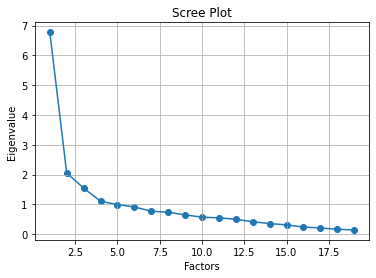

In [130]:
plt.scatter(range(1, items_casp19_w6_df.shape[1]+1), ev_casp19_w6)
plt.plot(range(1, items_casp19_w6_df.shape[1]+1), ev_casp19_w6)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [131]:
fa_casp19_w6.loadings_

array([[-0.00192545,  0.69665507, -0.26359643,  0.21745444],
       [-0.08977319,  0.36242678,  0.09475817,  0.05992345],
       [ 0.1947104 ,  0.33928349,  0.23588896,  0.19706517],
       [-0.14320568, -0.09077698,  0.69995975,  0.09284865],
       [ 0.02303273,  0.68136251, -0.28206102,  0.37459844],
       [ 0.01090417,  0.04502604,  0.51687614,  0.35122714],
       [ 0.15735416,  0.63282256,  0.20759477, -0.03546477],
       [-0.06117714,  0.20043778,  0.02751451,  0.21094854],
       [ 0.0838818 ,  0.04192303,  0.47282438, -0.11224105],
       [ 0.87632929, -0.04989644, -0.11426163, -0.0040306 ],
       [ 0.93514202, -0.04876384, -0.04569026, -0.15221051],
       [ 0.73470774, -0.12933346,  0.17815383, -0.02821801],
       [ 0.34627111,  0.25889686, -0.03177566, -0.08810924],
       [ 0.82712054, -0.11317957,  0.01578723,  0.32459176],
       [ 0.21628338,  0.61826709,  0.01830686,  0.1735242 ],
       [-0.00228811,  0.71702976, -0.02382407, -0.08656513],
       [ 0.73554116, -0.

In [132]:
fa_casp19_w6.get_factor_variance() #primera fila loadings, segunda proporción de varianza explicada y la tercera varianza acumulada

(array([4.26782837, 2.75941635, 1.3614106 , 0.70611435]),
 array([0.22462255, 0.14523244, 0.07165319, 0.03716391]),
 array([0.22462255, 0.36985499, 0.44150817, 0.47867209]))

#### Confirmatorio

##### Especificación del modelo 

Estimar los parámetros

> El tipo de análisis que viene en el paquete de Factor Analyzer

In [133]:
casp_19_w6_dict = {'control': ['scqola', 'scqolb', 'scqolc', 'scqold'],
                   'autonomy': ['scqole', 'scqolf', 'scqolg', 'scqolh', 'scqoli'],
                   'pleasure': [ 'scqolj', 'scqolk', 'scqoll', 'scqolm', 'scqoln'],
                   'self_realization': ['scqolo', 'scqolp', 'scqolq', 'scqolr', 'scqols']}

In [134]:
casp_19_w6_spec = ModelSpecificationParser.parse_model_specification_from_dict(items_casp19_w6_df, casp_19_w6_dict)

In [135]:
cfa_casp_19_w6_spec = ConfirmatoryFactorAnalyzer(casp_19_w6_spec, disp=False)

In [136]:
cfa_casp_19_w6_spec.fit(items_casp19_w6_df.values)

/opt/conda/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=84,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7f8f0e01c090>,
                           tol=None)

In [137]:
cfa_casp_19_w6_spec.loadings_

array([[0.94492227, 0.        , 0.        , 0.        ],
       [1.13459   , 0.        , 0.        , 0.        ],
       [0.92230621, 0.        , 0.        , 0.        ],
       [0.85529699, 0.        , 0.        , 0.        ],
       [0.        , 0.94986215, 0.        , 0.        ],
       [0.        , 0.94297686, 0.        , 0.        ],
       [0.        , 0.94837738, 0.        , 0.        ],
       [0.        , 1.02358932, 0.        , 0.        ],
       [0.        , 0.98726218, 0.        , 0.        ],
       [0.        , 0.        , 0.99849893, 0.        ],
       [0.        , 0.        , 0.99126419, 0.        ],
       [0.        , 0.        , 0.9326037 , 0.        ],
       [0.        , 0.        , 0.91059808, 0.        ],
       [0.        , 0.        , 0.98147499, 0.        ],
       [0.        , 0.        , 0.        , 0.96594766],
       [0.        , 0.        , 0.        , 0.91232989],
       [0.        , 0.        , 0.        , 0.92085726],
       [0.        , 0.        ,

In [138]:
cfa_casp_19_w6_spec.factor_varcovs_

array([[1.        , 0.09173813, 0.07426923, 0.08752234],
       [0.09173813, 1.        , 0.0795434 , 0.10128656],
       [0.07426923, 0.0795434 , 1.        , 0.10329269],
       [0.08752234, 0.10128656, 0.10329269, 1.        ]])

In [139]:
cfa_casp_19_w6_spec.get_standard_errors

<bound method ConfirmatoryFactorAnalyzer.get_standard_errors of ConfirmatoryFactorAnalyzer(bounds=None, disp=False, impute='median',
                           is_cov_matrix=False, max_iter=200, n_obs=84,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7f8f0e01c090>,
                           tol=None)>

- Isolation

In [141]:
chi_square_value_isolation_w6, p_value_isolation_w6 = calculate_bartlett_sphericity(items_isolation_w6_df)

In [142]:
chi_square_value_isolation_w6, p_value_isolation_w6

(29.604904206772844, 0.00037279506404449625)

> P valor bueno

In [143]:
kmo_all_isolation_w6, kmo_model_isolation_w6 = calculate_kmo(items_isolation_w6_df)

In [144]:
kmo_all_isolation_w6

array([0.4941642 , 0.62191177, 0.53257936, 0.53486191, 0.51243172])

In [145]:
kmo_model_isolation_w6

0.52668238811417

>Kmo bueno

In [146]:
fa_isolation_w6 = FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [147]:
fa_isolation_w6.fit(items_isolation_w6_df)

FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [148]:
ev_isolation_w6, v_isolation_w6 = fa_isolation_w6.get_eigenvalues()

In [149]:
ev_isolation_w6, v_isolation_w6

(array([1.58589883, 1.18388885, 0.90500555, 0.75294944, 0.57225732]),
 array([ 1.21352932,  0.64134917,  0.04479153, -0.01007081, -0.0280954 ]))

> Duda: dos autovalores tienen valor por encima de 1, ¿Puedo coger un solo factor basándome en la teoría o no es posible?

/bin/sh: 1: TRANSFORMAR: not found


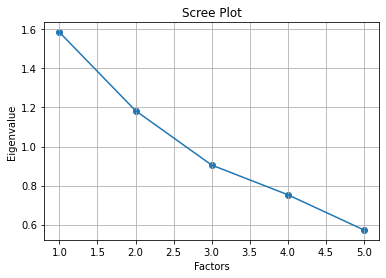

In [174]:
plt.scatter(range(1, items_isolation_w6_df.shape[1]+1), ev_isolation_w6)
plt.plot(range(1, items_isolation_w6_df.shape[1]+1), ev_isolation_w6)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [150]:
fa_isolation_w6.loadings_

array([[-0.35217621, -0.03519272],
       [-0.09297901,  0.22001189],
       [ 0.19196707,  0.67566158],
       [-0.03996891,  0.45788017],
       [ 0.98654308, -0.03602677]])

In [151]:
fa_isolation_w6.get_factor_variance() # ['loadings', 'proporción de varianza explicada', 'varianza acumulada']

(array([1.1443893, 0.7171145]),
 array([0.22887786, 0.1434229 ]),
 array([0.22887786, 0.37230076]))

#### Confirmatorio

### 6.2) Ola 8

In [152]:
fa_casp19_w8 = fa_casp19_w6

In [153]:
fa_isolation_w8 = fa_isolation_w6

## 7) Segundo tratamiento de valores perdidos

### 7.1) Ola 6

In [154]:
second_cols_to_clean_out_of_sample_w6 = isolation_w6_cols + casp19_w6_cols + sexdissa_w6_m_cols + sexdissa_w6_f_cols

- **"-2": "schedule not aplicable"** : *Cuestionarios, compuestos por sus ítems, que van a ser revisados para eliminar sujetos que no formaban parte de la muestra en estos módulos de ELSA. 1902 mujeres y 1620 hombres no han recibido módulo de sexualidad del cuestionario* 

In [155]:
second_sbj_out_of_sample_w6 = w6_first_cleaned_df.loc[pd.DataFrame([(w6_first_cleaned_df[col] == -2) for col in second_cols_to_clean_out_of_sample_w6]).any()].index

In [156]:
second_sbj_out_of_sample_w6

Int64Index([0, 35, 38, 39, 45, 52, 56, 61, 66, 70, 86], dtype='int64')

In [157]:
w6_without_second_sbj_out_of_sample_df = w6_first_cleaned_df.drop(second_sbj_out_of_sample_w6)
#w6_without_second_sbj_out_of_sample_df

 * -9 Sujetos que no contestan a alguna de las preguntas del cuestionario de satisfacción sexual

In [158]:
second_sbj_didnt_awr_w6 = w6_without_second_sbj_out_of_sample_df.loc[pd.DataFrame([(w6_without_second_sbj_out_of_sample_df[col] == -9) for col in second_cols_to_clean_out_of_sample_w6]).any()].index

In [159]:
w6_without_second_sbj_didnt_awr_df = w6_without_second_sbj_out_of_sample_df.drop(second_sbj_didnt_awr_w6)
# w6_without_second_sbj_didnt_awr_df

* -1 (item no aplicable) en sexdissa w6 (Sería conveniente encontrar una manera menos drástica de tratar con los valores perdidos de los items)

In [160]:
second_sbj_item_not_applicable_w6 = w6_without_second_sbj_didnt_awr_df.loc[pd.DataFrame([(w6_without_second_sbj_didnt_awr_df[col] == -1) for col in second_cols_to_clean_out_of_sample_w6]).any()].index

In [161]:
w6_without_second_sbj_item_not_applicable_df = w6_without_second_sbj_didnt_awr_df.drop(second_sbj_item_not_applicable_w6)

In [162]:
w6_second_cleaned_df = w6_without_second_sbj_item_not_applicable_df #sustituir por el nombre del df más reciente tras la limpieza

## Test cutres

In [163]:
w6_second_cleaned_df.loc[w6_second_cleaned_df['q3'] < 0, ['q3']]

,q3


In [164]:
w6_second_cleaned_df.loc[w6_second_cleaned_df['q9'] < 0, ['q9']]

,q9


### 8.1) Ola 6

* Insatisfacción sexual para la ola 6 (mujeres)-> sexdissa_w6_f

In [165]:
sexdissa_w6_f= w6_second_cleaned_df.loc[(w6_second_cleaned_df['indsex'] == 2), # <- 1 = men ; 2 = women
                   sexdissa_w6_f_cols]
sexdissa_w6_f # Mientras haya números en negativo hay valores perdidos incluídos en la base de datos. 

,q3,q9,q10,q14f,q15f,q19m19f,q28m25f,q32m26f


* Insatisfacción sexual para la ola 6 (hombres)

In [166]:
sexdissa_w6_m = w6_second_cleaned_df.loc[(w6_second_cleaned_df['indsex'] == 1), # <- 1 = men ; 2 = women
                   sexdissa_w6_m_cols]
sexdissa_w6_m

,q3,q9,q10,q13m,q17m,q19m19f,q21m,q28m25f,q32m26f


### 8.2) Ola 8

* insatisfacción sexual 

## 9) Análisis factoriales de los segundos cuestionarios - datos preliminares hasta construir cuestionario y limpiar valores perdidos

### 9.1) Ola 6

* sexdissa_w6_m

In [167]:
chi_square_value_sexdissa_w6_m,p_value_sexdissa_w6_m = calculate_bartlett_sphericity(sexdissa_w6_m)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/factor_analyzer/utils.py:71: RuntimeWarning: Degrees of freedom <= 0 for slice
  r = np.cov(x, rowvar=False, ddof=ddof)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [168]:
chi_square_value_sexdissa_w6_m,p_value_sexdissa_w6_m

(nan, nan)

In [169]:
kmo_all_sexdissa_w6_m, Kmo_model_sexdissa_w6_m = calculate_kmo(sexdissa_w6_m)

In [170]:
kmo_all_sexdissa_w6_m

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [171]:
Kmo_model_sexdissa_w6_m

nan

In [172]:
fa_sexdissa_w6_m = FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=3, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [173]:
fa_sexdissa_w6_m.fit(sexdissa_w6_m)

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by FactorAnalyzer.

In [ ]:
ev_sexdissa_w6_m, v_sexdissa_w6_m = fa_sexdissa_w6_m.get_eigenvalues()

In [ ]:
plt.scatter(range(1, sexdissa_w6_m.shape[1]+1), ev_sexdissa_w6_m)
plt.plot(range(1, sexdissa_w6_m.shape[1]+1), ev_sexdissa_w6_m)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

* sexdissa_w6_f

In [ ]:
chi_square_value_sexdissa_w6_f, p_value_value_sexdissa_w6_f = calculate_bartlett_sphericity(sexdissa_w6_f)

In [ ]:
chi_square_value_value_sexdissa_w6_f, p_value_value_sexdissa_w6_f

In [ ]:
kmo_all_value_sexdissa_w6_f, kmo_model_value_sexdissa_w6_f = calculate_kmo(sexdissa_w6_f)

In [ ]:
kmo_all_value_sexdissa_w6_f

In [ ]:
kmo_model_value_sexdissa_w6_f

In [ ]:
fa_sexdissa_w6_f= FactorAnalyzer(bounds=(0.005, 1), impute='drop', is_corr_matrix=False,
               method='minres', n_factors=3, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [ ]:
fa_sexdissa_w6_f.fit(sexdissa_w6_f)

In [ ]:
ev_sexdissa_w6_f, v_sexdissa_w6_f = fa_sexdissa_w6_f.get_eigenvalues()

In [ ]:
plt.scatter(range(1, sexdissa_w6_f.shape[1]+1), ev_sexdissa_w6_f)
plt.plot(range(1, sexdissa_w6_f.shape[1]+1), ev_sexdissa_w6_f)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### 9.2) Ola 8